# Natural language image search with a Dual Encoder

**Author:** [Khalid Salama](https://www.linkedin.com/in/khalid-salama-24403144/)<br>
**Date created:** 2021/01/30<br>
**Last modified:** 2021/01/30<br>
**Description:** Implementation of a dual encoder model for retrieving images that match natural language queries.


## Introduction

The example demonstrates how to build a dual encoder (also known as two-tower) neural network
model to search for images using natural language. The model is inspired by
the [CLIP](https://openai.com/blog/clip/)
approach, introduced by Alec Radford et al. The idea is to train a vision encoder and a text
encoder jointly to project the representation of images and their captions into the same embedding
space, such that the caption embeddings are located near the embeddings of the images they describe.

This example requires TensorFlow 2.4 or higher.
In addition, [TensorFlow Hub](https://www.tensorflow.org/hub)
and [TensorFlow Text](https://www.tensorflow.org/tutorials/tensorflow_text/intro)
are required for the BERT model, and [TensorFlow Addons](https://www.tensorflow.org/addons)
is required for the AdamW optimizer. These libraries can be installed using the
following command:

```python
pip install -q -U tensorflow-hub tensorflow-text tensorflow-addons
```


## Setup


In [1]:
# !pip install -q -U tensorflow==2.15.* tensorflow-hub tensorflow-text==2.15.* #keras

In [2]:
# !pip show tensorflow tensorflow-hub tensorflow-text keras numpy

In [1]:
import os
import collections
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow_text as text

# import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import pdb

# Suppressing tf.hub warnings
tf.get_logger().setLevel("ERROR")

2024-05-06 02:42:53.639693: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Prepare the data

We will use the [MS-COCO](https://cocodataset.org/#home) dataset to train our
dual encoder model. MS-COCO contains over 82,000 images, each of which has at least
5 different caption annotations. The dataset is usually used for
[image captioning](https://www.tensorflow.org/tutorials/text/image_captioning)
tasks, but we can repurpose the image-caption pairs to train our dual encoder
model for image search.

###

Download and extract the data

First, let's download the dataset, which consists of two compressed folders:
one with images, and the other—with associated image captions.
Note that the compressed images folder is 13GB in size.


In [2]:
root_dir = "datasets"
annotations_dir = os.path.join(root_dir, "annotations")
images_dir = os.path.join(root_dir, "train2014")
tfrecords_dir = os.path.join(root_dir, "tfrecords")
annotation_file = os.path.join(annotations_dir, "captions_train2014.json")

# Download caption annotation files
if not os.path.exists(annotations_dir):
    annotation_zip = keras.utils.get_file(
        "captions.zip",
        cache_dir=os.path.abspath("."),
        origin="http://images.cocodataset.org/annotations/annotations_trainval2014.zip",
        extract=True,
    )
    os.remove(annotation_zip)

# Download image files
if not os.path.exists(images_dir):
    image_zip = keras.utils.get_file(
        "train2014.zip",
        cache_dir=os.path.abspath("."),
        origin="http://images.cocodataset.org/zips/train2014.zip",
        extract=True,
    )
    os.remove(image_zip)

print("Dataset is downloaded and extracted successfully.")

with open(annotation_file, "r") as f:
    annotations = json.load(f)["annotations"]

image_path_to_caption = collections.defaultdict(list)
for element in annotations:
    caption = f"{element['caption'].lower().rstrip('.')}"
    image_path = images_dir + "/COCO_train2014_" + "%012d.jpg" % (element["image_id"])
    image_path_to_caption[image_path].append(caption)

image_paths = list(image_path_to_caption.keys())
print(f"Number of images: {len(image_paths)}")

13510573713/13510573713 [==============================] - 1218s 0us/step
Dataset is downloaded and extracted successfully.
Number of images: 82783


### Process and save the data to TFRecord files

You can change the `sample_size` parameter to control many image-caption pairs
will be used for training the dual encoder model.
In this example we set `train_size` to 30,000 images,
which is about 35% of the dataset. We use 2 captions for each
image, thus producing 60,000 image-caption pairs. The size of the training set
affects the quality of the produced encoders, but more examples would lead to
longer training time.


In [3]:
train_size = 30000
valid_size = 5000
captions_per_image = 2
images_per_file = 2000

train_image_paths = image_paths[:train_size]
num_train_files = int(np.ceil(train_size / images_per_file))
train_files_prefix = os.path.join(tfrecords_dir, "train")

valid_image_paths = image_paths[-valid_size:]
num_valid_files = int(np.ceil(valid_size / images_per_file))
valid_files_prefix = os.path.join(tfrecords_dir, "valid")

tf.io.gfile.makedirs(tfrecords_dir)


def bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def create_example(image_path, caption):
    feature = {
        "caption": bytes_feature(caption.encode()),
        "raw_image": bytes_feature(tf.io.read_file(image_path).numpy()),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))


def write_tfrecords(file_name, image_paths):
    caption_list = []
    image_path_list = []
    for image_path in image_paths:
        captions = image_path_to_caption[image_path][:captions_per_image]
        caption_list.extend(captions)
        image_path_list.extend([image_path] * len(captions))

    with tf.io.TFRecordWriter(file_name) as writer:
        for example_idx in range(len(image_path_list)):
            example = create_example(image_path_list[example_idx], caption_list[example_idx])
            writer.write(example.SerializeToString())
    return example_idx + 1


def write_data(image_paths, num_files, files_prefix):
    example_counter = 0
    for file_idx in tqdm(range(num_files)):
        file_name = files_prefix + "-%02d.tfrecord" % (file_idx)
        start_idx = images_per_file * file_idx
        end_idx = start_idx + images_per_file
        example_counter += write_tfrecords(file_name, image_paths[start_idx:end_idx])
    return example_counter


train_example_count = write_data(train_image_paths, num_train_files, train_files_prefix)
print(f"{train_example_count} training examples were written to tfrecord files.")

valid_example_count = write_data(valid_image_paths, num_valid_files, valid_files_prefix)
print(f"{valid_example_count} evaluation examples were written to tfrecord files.")

  0%|          | 0/3 [00:00<?, ?it/s]

60000 training examples were written to tfrecord files.


100%|██████████| 3/3 [00:09<00:00,  3.26s/it]

10000 evaluation examples were written to tfrecord files.


### Create `tf.data.Dataset` for training and evaluation


In [4]:
feature_description = {
    "caption": tf.io.FixedLenFeature([], tf.string),
    "raw_image": tf.io.FixedLenFeature([], tf.string),
}


def read_example(example):
    features = tf.io.parse_single_example(example, feature_description)
    raw_image = features.pop("raw_image")
    features["image"] = tf.image.resize(tf.image.decode_jpeg(raw_image, channels=3), size=(299, 299))
    return features


def get_dataset(file_pattern, batch_size):

    return (
        tf.data.TFRecordDataset(tf.data.Dataset.list_files(file_pattern))
        .map(
            read_example,
            num_parallel_calls=tf.data.AUTOTUNE,
            deterministic=False,
        )
        .shuffle(batch_size * 10)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
        .batch(batch_size)
    )

## Implement the projection head

The projection head is used to transform the image and the text embeddings to
the same embedding space with the same dimensionality.


In [5]:
def project_embeddings(embeddings, num_projection_layers, projection_dims, dropout_rate):
    # Use gelu activations within keras
    projected_embeddings = layers.Dense(units=projection_dims, activation=tf.nn.gelu)(embeddings)
    for _ in range(num_projection_layers):
        # x = tf.nn.gelu(projected_embeddings)
        x = layers.Dense(projection_dims, activation=tf.nn.gelu)(projected_embeddings)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.Add()([projected_embeddings, x])
        # Layer normalization
        projected_embeddings = layers.LayerNormalization()(x)
    return projected_embeddings

## Implement the vision encoder

In this example, we use [Xception](https://keras.io/api/applications/xception/)
from [Keras Applications](https://keras.io/api/applications/) as the base for the
vision encoder.


In [6]:
def create_vision_encoder(num_projection_layers, projection_dims, dropout_rate, trainable=False):
    # Load the pre-trained Xception model to be used as the base encoder.
    xception = keras.applications.Xception(include_top=False, weights="imagenet", pooling="avg")
    # Set the trainability of the base encoder.
    for layer in xception.layers:
        layer.trainable = trainable
    # Receive the images as inputs.
    inputs = layers.Input(shape=(299, 299, 3), name="image_input")

    # Preprocess the input image.
    xception_input = keras.applications.xception.preprocess_input(inputs)
    # Generate the embeddings for the images using the xception model.
    embeddings = xception(xception_input)
    # Project the embeddings produced by the model.
    outputs = project_embeddings(embeddings, num_projection_layers, projection_dims, dropout_rate)
    # Create the vision encoder model.
    return keras.Model(inputs, outputs, name="vision_encoder")

## Implement the text encoder

We use [BERT](https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1)
from [TensorFlow Hub](https://tfhub.dev) as the text encoder


In [7]:
def create_text_encoder(num_projection_layers, projection_dims, dropout_rate, trainable=False):
    # Load the BERT preprocessing module.
    preprocess = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
        name="text_preprocessing",
    )
    # Load the pre-trained BERT model to be used as the base encoder.
    # Set the trainability of the base encoder.
    bert = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1",
        trainable=trainable,
        name="bert",
    )
    # Receive the text as inputs.
    inputs = layers.Input(shape=(), dtype=tf.string, name="text_input")
    # Preprocess the text.
    bert_inputs = preprocess(inputs)
    # Generate embeddings for the preprocessed text using the BERT model.
    embeddings = bert(bert_inputs)["pooled_output"]
    # Project the embeddings produced by the model.
    outputs = project_embeddings(embeddings, num_projection_layers, projection_dims, dropout_rate)
    # Create the text encoder model.
    return keras.Model(inputs, outputs, name="text_encoder")

## Implement the dual encoder

To calculate the loss, we compute the pairwise dot-product similarity between
each `caption_i` and `images_j` in the batch as the predictions.
The target similarity between `caption_i` and `image_j` is computed as
the average of the (dot-product similarity between `caption_i` and `caption_j`)
and (the dot-product similarity between `image_i` and `image_j`).
Then, we use crossentropy to compute the loss between the targets and the predictions.


In [8]:
class DualEncoder(keras.Model):
    def __init__(self, text_encoder, image_encoder, temperature=1.0, **kwargs):
        super().__init__(**kwargs)
        self.text_encoder = text_encoder
        self.image_encoder = image_encoder
        self.temperature = temperature
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, features, training=False):
        # Place each encoder on a separate GPU (if available).
        # TF will fallback on available devices if there are fewer than 2 GPUs.
        with tf.device("/gpu:0"):
            # Get the embeddings for the captions.
            caption_embeddings = text_encoder(features["caption"], training=training)
        with tf.device("/gpu:1"):
            # Get the embeddings for the images.
            image_embeddings = vision_encoder(features["image"], training=training)
        return caption_embeddings, image_embeddings

    def compute_loss(self, caption_embeddings, image_embeddings):
        # logits[i][j] is the dot_similarity(caption_i, image_j).
        logits = tf.matmul(caption_embeddings, image_embeddings, transpose_b=True) / self.temperature
        # images_similarity[i][j] is the dot_similarity(image_i, image_j).
        images_similarity = tf.matmul(image_embeddings, image_embeddings, transpose_b=True)
        # captions_similarity[i][j] is the dot_similarity(caption_i, caption_j).
        captions_similarity = tf.matmul(caption_embeddings, caption_embeddings, transpose_b=True)
        # targets[i][j] = avarage dot_similarity(caption_i, caption_j) and dot_similarity(image_i, image_j).
        targets = keras.activations.softmax((captions_similarity + images_similarity) / (2 * self.temperature))
        # Compute the loss for the captions using crossentropy
        captions_loss = keras.losses.categorical_crossentropy(y_true=targets, y_pred=logits, from_logits=True)
        # Compute the loss for the images using crossentropy
        images_loss = keras.losses.categorical_crossentropy(
            y_true=tf.transpose(targets), y_pred=tf.transpose(logits), from_logits=True
        )
        # Return the mean of the loss over the batch.
        return (captions_loss + images_loss) / 2

    def train_step(self, features):
        with tf.GradientTape() as tape:
            # Forward pass
            caption_embeddings, image_embeddings = self(features, training=True)
            loss = self.compute_loss(caption_embeddings, image_embeddings)
        # Backward pass
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        # Monitor loss
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, features):
        caption_embeddings, image_embeddings = self(features, training=False)
        loss = self.compute_loss(caption_embeddings, image_embeddings)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

## Train the dual encoder model

In this experiment, we freeze the base encoders for text and images, and make only
the projection head trainable.


In [9]:
num_epochs = 5  # In practice, train for at least 30 epochs
batch_size = 256
# %debug
vision_encoder = create_vision_encoder(num_projection_layers=1, projection_dims=256, dropout_rate=0.1)
text_encoder = create_text_encoder(num_projection_layers=1, projection_dims=256, dropout_rate=0.1)
dual_encoder = DualEncoder(text_encoder, vision_encoder, temperature=0.05)
dual_encoder.compile(optimizer=keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001))

83683744/83683744 [==============================] - 3s 0us/step


Note that training the model with 60,000 image-caption pairs, with a batch size of 256,
takes around 12 minutes per epoch using a V100 GPU accelerator. If 2 GPUs are available,
the epoch takes around 8 minutes.


In [10]:
print(f"Number of GPUs: {len(tf.config.list_physical_devices('GPU'))}")
print(f"Number of examples (caption-image pairs): {train_example_count}")
print(f"Batch size: {batch_size}")
print(f"Steps per epoch: {int(np.ceil(train_example_count / batch_size))}")
train_dataset = get_dataset(os.path.join(tfrecords_dir, "train-*.tfrecord"), batch_size)
valid_dataset = get_dataset(os.path.join(tfrecords_dir, "valid-*.tfrecord"), batch_size)
# Create a learning rate scheduler callback.
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3)
# Create an early stopping callback.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
history = dual_encoder.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=[reduce_lr, early_stopping],
)
print("Training completed. Saving vision and text encoders...")
vision_encoder.save("vision_encoder")
text_encoder.save("text_encoder")
print("Models are saved.")

Number of GPUs: 0
Number of examples (caption-image pairs): 60000
Batch size: 256
Steps per epoch: 235
Epoch 1/5
235/235 [==============================] - 11698s 50s/step - loss: 54.3105 - val_loss: 8.4893 - lr: 0.0010
Epoch 2/5
235/235 [==============================] - 9999s 43s/step - loss: 7.1230 - val_loss: 5.6795 - lr: 0.0010
Epoch 3/5
235/235 [==============================] - 13491s 57s/step - loss: 5.1456 - val_loss: 5.1900 - lr: 0.0010
Epoch 4/5
235/235 [==============================] - 10303s 44s/step - loss: 4.5744 - val_loss: 4.9468 - lr: 0.0010
Epoch 5/5
235/235 [==============================] - 10636s 45s/step - loss: 4.2488 - val_loss: 4.8128 - lr: 0.0010
Training completed. Saving vision and text encoders...
Models are saved.


Plotting the training loss:


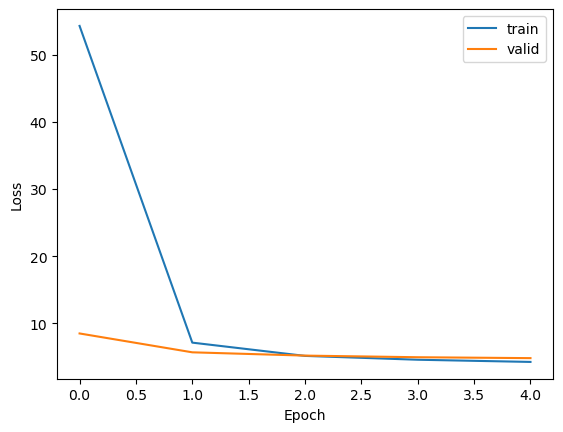

In [11]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="upper right")
plt.show()

## Search for images using natural language queries

We can then retrieve images corresponding to natural language queries via
the following steps:

1. Generate embeddings for the images by feeding them into the `vision_encoder`.
2. Feed the natural language query to the `text_encoder` to generate a query embedding.
3. Compute the similarity between the query embedding and the image embeddings
   in the index to retrieve the indices of the top matches.
4. Look up the paths of the top matching images to display them.

Note that, after training the `dual encoder`, only the fine-tuned `vision_encoder`
and `text_encoder` models will be used, while the `dual_encoder` model will be discarded.


### Generate embeddings for the images

We load the images and feed them into the `vision_encoder` to generate their embeddings.
In large scale systems, this step is performed using a parallel data processing framework,
such as [Apache Spark](https://spark.apache.org) or [Apache Beam](https://beam.apache.org).
Generating the image embeddings may take several minutes.


In [12]:
print("Loading vision and text encoders...")
vision_encoder = keras.models.load_model("vision_encoder")
text_encoder = keras.models.load_model("text_encoder")
print("Models are loaded.")


def read_image(image_path):
    image_array = tf.image.decode_jpeg(tf.io.read_file(image_path), channels=3)
    return tf.image.resize(image_array, (299, 299))


print(f"Generating embeddings for {len(image_paths)} images...")
image_embeddings = vision_encoder.predict(
    tf.data.Dataset.from_tensor_slices(image_paths).map(read_image).batch(batch_size),
    verbose=1,
)
print(f"Image embeddings shape: {image_embeddings.shape}.")

Loading vision and text encoders...
Models are loaded.
Generating embeddings for 82783 images...
324/324 [==============================] - 12691s 39s/step
Image embeddings shape: (82783, 256).


### Retrieve relevant images

In this example, we use exact matching by computing the dot product similarity
between the input query embedding and the image embeddings, and retrieve the top k
matches. However, _approximate_ similarity matching, using frameworks like
[ScaNN](https://github.com/google-research/google-research/tree/master/scann),
[Annoy](https://github.com/spotify/annoy), or [Faiss](https://github.com/facebookresearch/faiss)
is preferred in real-time use cases to scale with a large number of images.


In [13]:
def find_matches(image_embeddings, queries, k=9, normalize=True):
    # Get the embedding for the query.
    query_embedding = text_encoder(tf.convert_to_tensor(queries))
    # Normalize the query and the image embeddings.
    if normalize:
        image_embeddings = tf.math.l2_normalize(image_embeddings, axis=1)
        query_embedding = tf.math.l2_normalize(query_embedding, axis=1)
    # Compute the dot product between the query and the image embeddings.
    dot_similarity = tf.matmul(query_embedding, image_embeddings, transpose_b=True)
    # Retrieve top k indices.
    results = tf.math.top_k(dot_similarity, k).indices.numpy()
    # Return matching image paths.
    return [[image_paths[idx] for idx in indices] for indices in results]

Set the `query` variable to the type of images you want to search for.
Try things like: 'a plate of healthy food',
'a woman wearing a hat is walking down a sidewalk',
'a bird sits near to the water', or 'wild animals are standing in a field'.


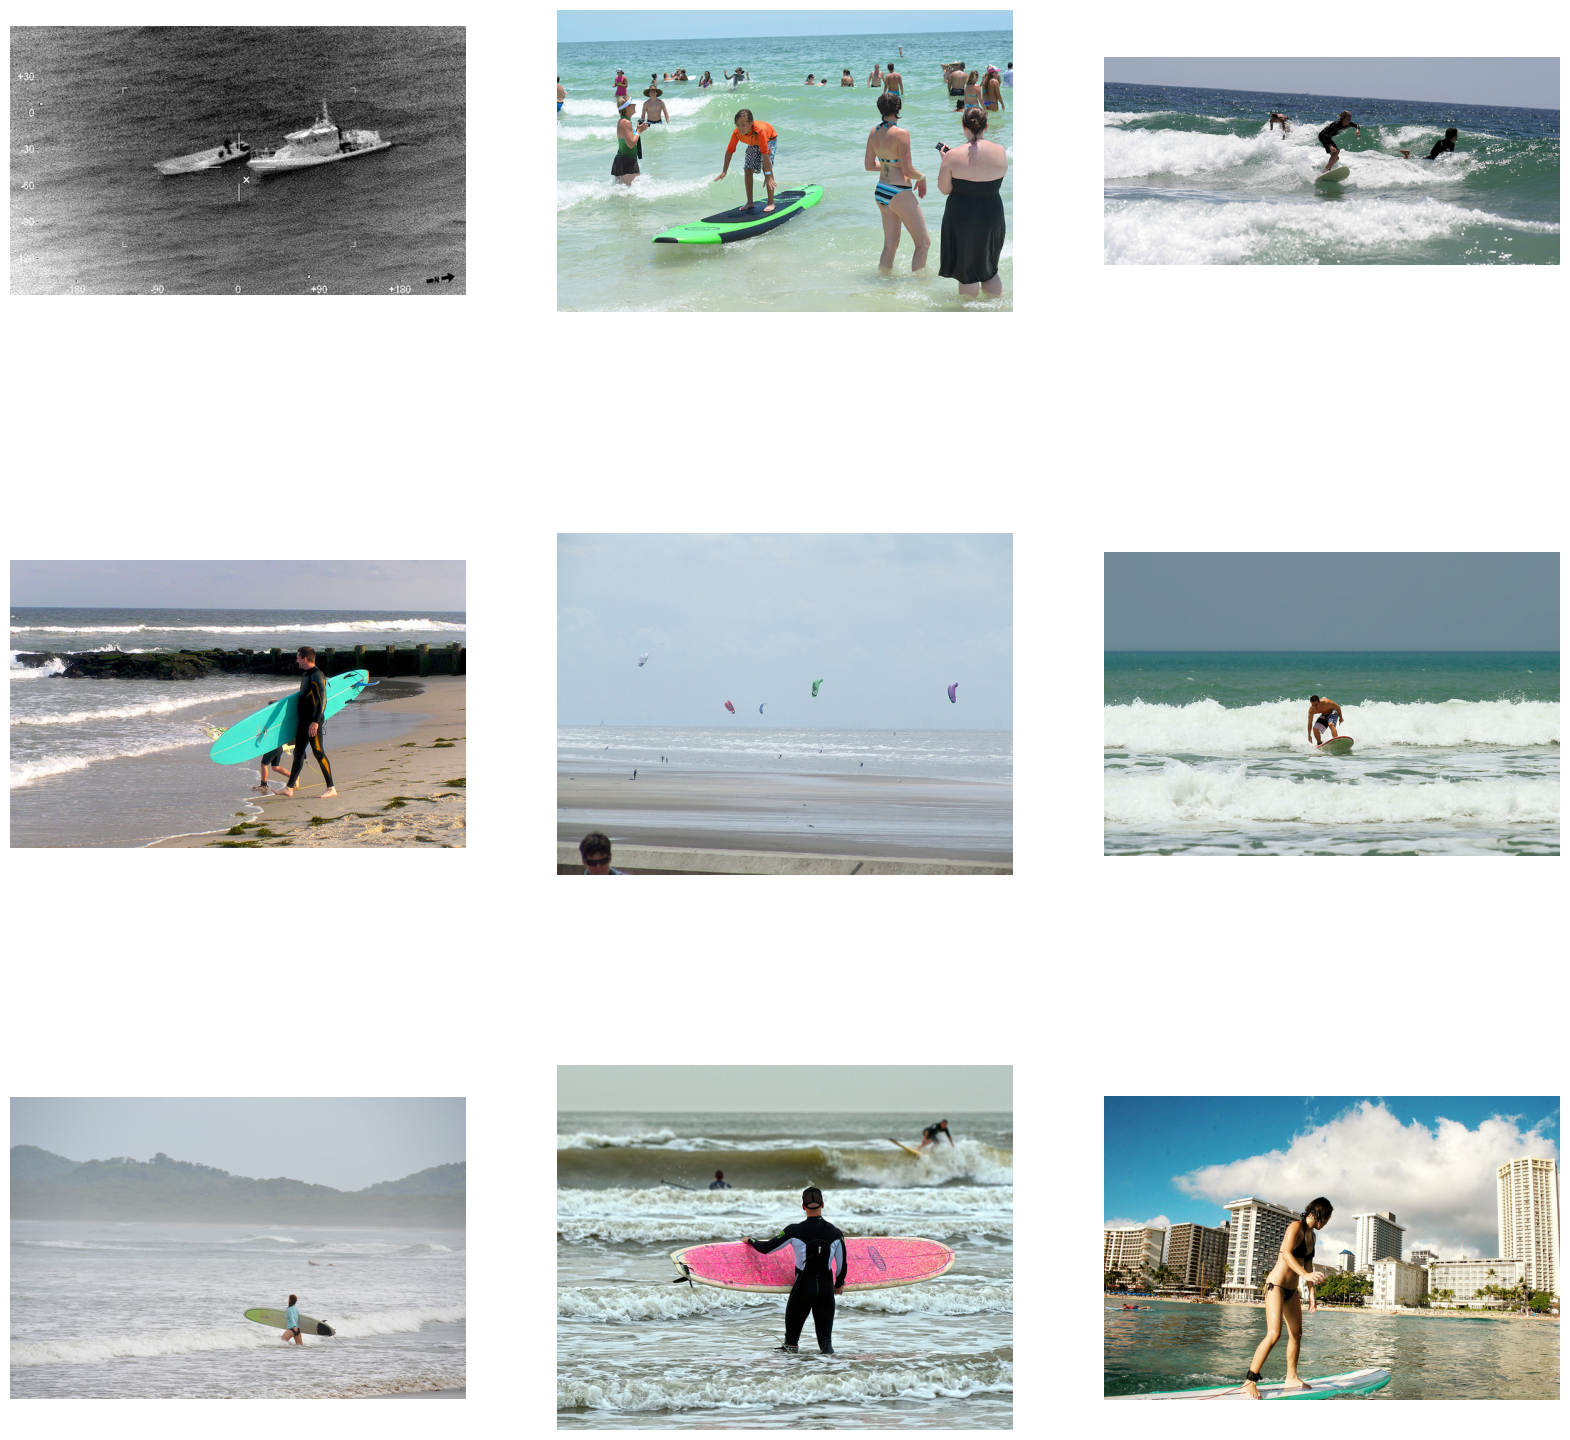

In [14]:
query = "a family standing next to the ocean on a sandy beach with a surf board"
matches = find_matches(image_embeddings, [query], normalize=True)[0]

plt.figure(figsize=(20, 20))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(mpimg.imread(matches[i]))
    plt.axis("off")

## Evaluate the retrieval quality

To evaluate the dual encoder model, we use the captions as queries.
We use the out-of-training-sample images and captions to evaluate the retrieval quality,
using top k accuracy. A true prediction is counted if, for a given caption, its associated image
is retrieved within the top k matches.


In [15]:
def compute_top_k_accuracy(image_paths, k=100):
    hits = 0
    num_batches = int(np.ceil(len(image_paths) / batch_size))
    for idx in tqdm(range(num_batches)):
        start_idx = idx * batch_size
        end_idx = start_idx + batch_size
        current_image_paths = image_paths[start_idx:end_idx]
        queries = [image_path_to_caption[image_path][0] for image_path in current_image_paths]
        result = find_matches(image_embeddings, queries, k)
        hits += sum([image_path in matches for (image_path, matches) in list(zip(current_image_paths, result))])

    return hits / len(image_paths)


print("Scoring training data...")
train_accuracy = compute_top_k_accuracy(train_image_paths)
print(f"Train accuracy: {round(train_accuracy * 100, 3)}%")

print("Scoring evaluation data...")
eval_accuracy = compute_top_k_accuracy(image_paths[train_size:])
print(f"Eval accuracy: {round(eval_accuracy * 100, 3)}%")

  0%|          | 0/118 [00:00<?, ?it/s]

Scoring training data...


  0%|          | 0/207 [00:00<?, ?it/s]

Train accuracy: 6.337%
Scoring evaluation data...


100%|██████████| 207/207 [40:02<00:00, 11.61s/it]

Eval accuracy: 2.677%


## Final remarks

You can obtain better results by increasing the size of the training sample,
train for more epochs, explore other base encoders for images and text,
set the base encoders to be trainable, and tune the hyperparameters,
especially the `temperature` for the softmax in the loss computation.

Example available on HuggingFace

|                                                                         Trained Model                                                                          |                                                                                  Demo                                                                                  |
| :------------------------------------------------------------------------------------------------------------------------------------------------------------: | :--------------------------------------------------------------------------------------------------------------------------------------------------------------------: |
| [![Generic badge](https://img.shields.io/badge/%F0%9F%A4%97%20Model-nl%20image%20search-black.svg)](https://huggingface.co/keras-io/dual-encoder-image-search) | [![Generic badge](https://img.shields.io/badge/%F0%9F%A4%97%20Spaces-nl%20image%20search-black.svg)](https://huggingface.co/spaces/keras-io/dual-encoder-image-search) |
